In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import meshio
import os
import time
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from tensorflow import keras


warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf


# Loading Dataset

In [2]:
x = np.arange(0.006, 0.0135, (0.0135-0.006)/300)
y = np.arange(0, 0.0025, 0.0025/75)

data_path = './Data'
path_sep = '\\' # use '/' for Unix and '\\' for Windows
folders = os.listdir(data_path)
        
subfolder = []
path = []
names = []
condition = []

for i in folders:
    if os.path.isdir(data_path + path_sep + i): 
        subfolder.append(data_path + path_sep + i)

for folder in subfolder:
    files = os.listdir(folder + path_sep)
    for i in files:
        ext = os.path.splitext(i)
        if (ext[-1].lower() == '.vtk') & (ext[0][-2] != '_'):
            names.append(ext[0])
            string = ext[0].replace('ER', '').replace('Tin', '').replace('Uin', '').replace('Twall', '').split('_')[0:4]
            var = []
            for j in string:
                if j == 'Adiabatic':
                    var.append(0.)
                else:
                    var.append(float(j))
            condition.append(var)

Q_list = []
for folder in subfolder:
    files = os.listdir(folder + path_sep)
    for counter,file in enumerate(files):
        mesh = meshio.read(folder+ path_sep +file)
        points = mesh.points
        Qdot = mesh.point_data['Qdot']
        boolArr = (points[:,1] == 0) & (points[:,0] >= 0.006)  
        Qdot = Qdot[boolArr]
        points = points[boolArr]
        old_points = points[:,[0, 2]]
        grid_x, grid_y = np.meshgrid(x, y)
        grid_new = griddata(old_points, Qdot, (grid_x, grid_y), method='nearest')
        Q_list.append(grid_new)
# Q_list

# Data Preparation

In [62]:
Qdot = np.array(Q_list)
Qdot = Qdot / np.max(Qdot)
mean = Qdot.mean(axis = 0)
Qdot = np.reshape(Qdot, (-1, 75, 300, 1))

normaliser = []
conditions = np.array(condition)
df = np.zeros(conditions.shape)
for i in range(conditions.shape[1]):
    df[:,i] = conditions[:,i] / np.max(conditions[:,i])
    normaliser.append(np.max(conditions[:,i]))

train_data, test_data, label_train, label_test = train_test_split(Qdot, df, test_size = 0.15)
print(train_data.shape)
print(df.shape)

# Manual train test split if needed
#test_index = 

#train_index = 

#test_data = Qdot[test_index]
#train_data = Qdot[train_index]
#label_train = df[train_index]
#label_test = df[test_index]

(203, 75, 300, 1)
(239, 4)


In [4]:
print(normaliser)
# df
# Equivalence ratio (1)
# Temperature (460)
# Velocity (0.50 m/s)
# Wall Temperature (373 or None)

[1000.0, 460.0, 50.0, 373.0]


array([[[[ 2.82242454e-13],
         [ 3.42620750e-13],
         [ 4.11951697e-13],
         ...,
         [ 1.85830003e-06],
         [ 1.85830003e-06],
         [ 8.68477500e-07]],

        [[ 3.43286258e-13],
         [ 4.16940882e-13],
         [ 5.01508667e-13],
         ...,
         [ 1.85686285e-06],
         [ 1.85686285e-06],
         [ 0.00000000e+00]],

        [[ 5.51527605e-13],
         [ 6.70750112e-13],
         [ 8.07686907e-13],
         ...,
         [ 1.85255739e-06],
         [ 1.85255739e-06],
         [ 0.00000000e+00]],

        ...,

        [[ 0.00000000e+00],
         [ 2.08010446e-06],
         [ 2.07208432e-06],
         ...,
         [-1.80194791e-06],
         [-1.80194791e-06],
         [ 0.00000000e+00]],

        [[ 0.00000000e+00],
         [ 1.69582112e-06],
         [ 1.68885792e-06],
         ...,
         [-1.80921548e-06],
         [-1.80921548e-06],
         [ 0.00000000e+00]],

        [[ 0.00000000e+00],
         [ 1.47417269e-06],
         [

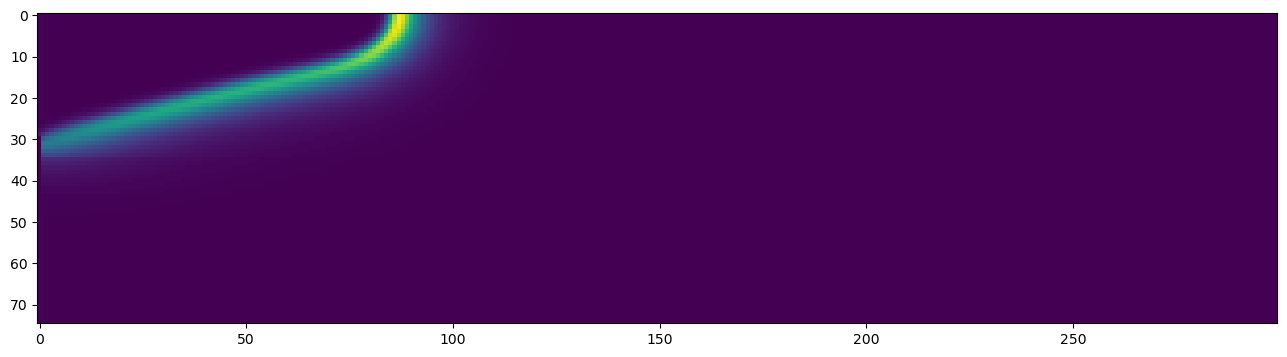

In [47]:
fig = plt.figure(figsize=(16, 80))
plt.imshow(np.reshape(Qdot[3],(75, 300)))
# plt.axis('off')
# image = next(iter(Qdot))
# image


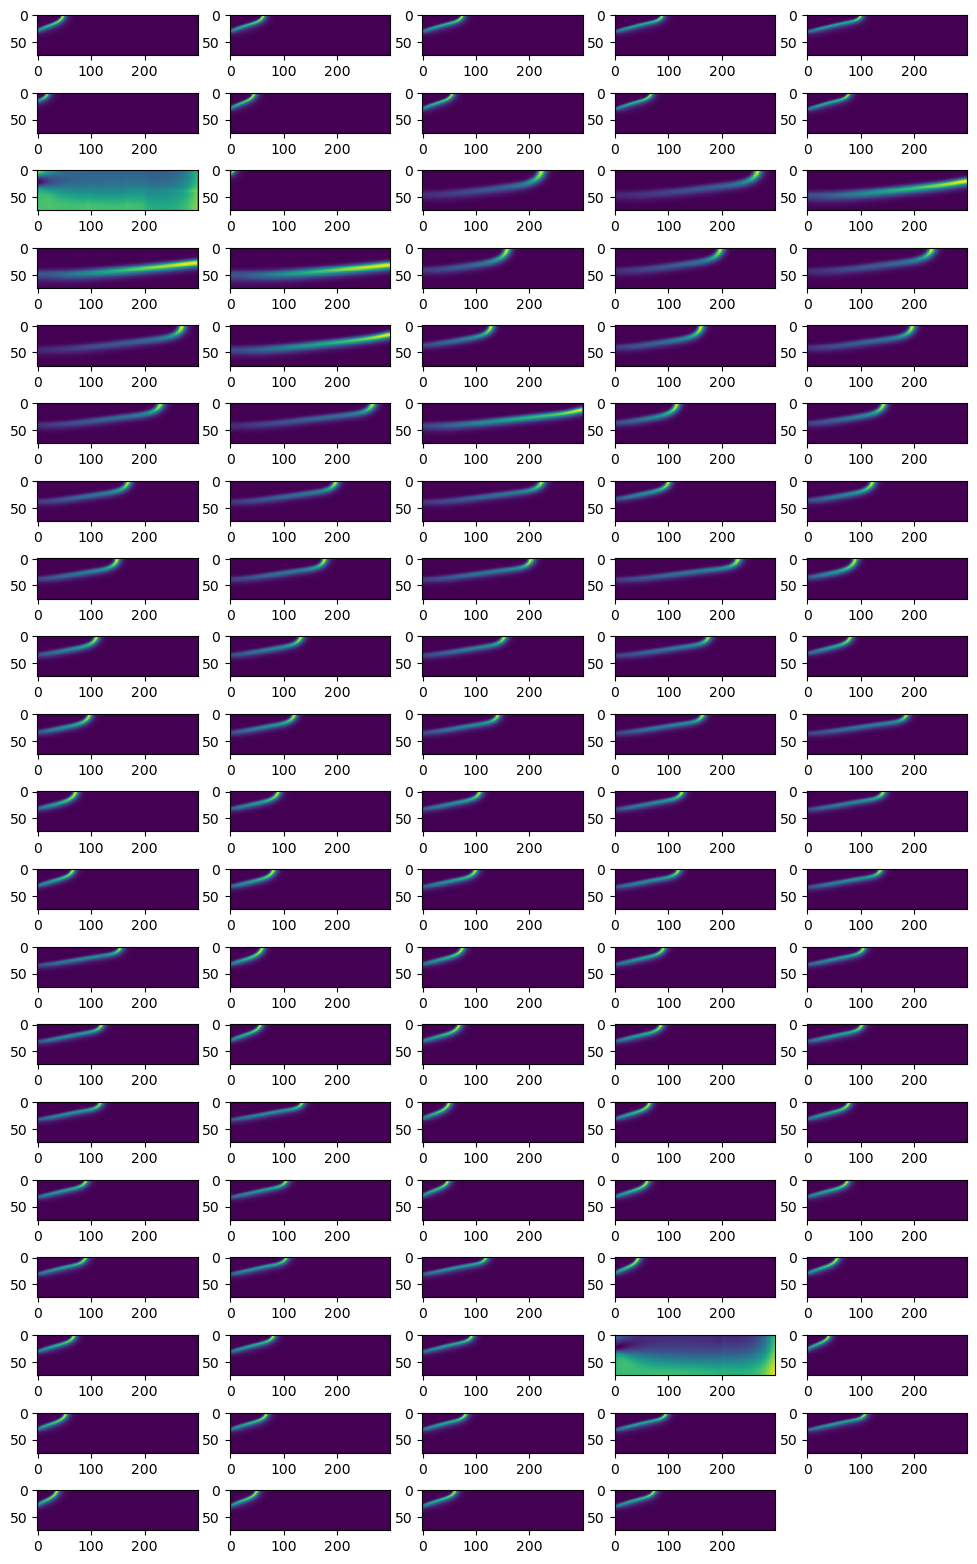

In [6]:
fig = plt.figure(figsize=(12, 20))
columns = 5
rows = 20

for i in range(1, columns * rows):
    img = Qdot[(i-1)]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## Get the outlier out(TODO)

## Convolutional Autoencoder
### Encoder Part

In [116]:
model =tf.keras.Sequential([
        # Input layer 
        tf.keras.layers.InputLayer(input_shape = (75,300,1)),
        
        # Conv layer + BatchNom + LeakyReLU + MaxPooling
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

        # Conv layer + BatchNom + LeakyReLU + MaxPooling
        tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=5,padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.MaxPooling2D(pool_size=(5, 5)),
        
        # Flatten  
        tf.keras.layers.Flatten(),
        
        # Fully NN --> Laten variables
        tf.keras.layers.Dense(latent_dim)
    ])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 75, 300, 32)       320       
                                                                 
 batch_normalization_40 (Ba  (None, 75, 300, 32)       128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 75, 300, 32)       0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 25, 100, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 5, 20, 64)         51264     
                                                                 
 batch_normalization_41 (Ba  (None, 5, 20, 64)       

In [112]:
class Autoencoder(tf.keras.Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    
    self.encoder = tf.keras.Sequential([
        # Input layer 
        tf.keras.layers.InputLayer(input_shape = (75,300,1)),
        
        # Conv layer + BatchNom + LeakyReLU + MaxPooling
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

        # Conv layer + BatchNom + LeakyReLU + MaxPooling
        tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=5,padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.MaxPooling2D(pool_size=(5, 5)),
        
        # Flatten  
        tf.keras.layers.Flatten(),
        
        # Fully NN --> Laten variables
        tf.keras.layers.Dense(latent_dim)
    ])
    
    self.decoder = tf.keras.Sequential([
                tf.keras.layers.InputLayer(input_shape = (latent_dim,)),
                
                # Fully NN 
                tf.keras.layers.Dense(units = 1*4*64),
                tf.keras.layers.Reshape(target_shape = (1,4,64)),
                
                # Conv layer 
                tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=5,padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LeakyReLU(),
                
                # Conv layer  
                tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=5,padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LeakyReLU(),
                
                # Conv layer 
                tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=3, padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Activation('sigmoid')
                ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


latent_dim = 4
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [113]:
# def ae_loss(y_true, y_pred):
#     loss = tf.keras.losses.mean_squared_error(y_true,y_pred)
#     return loss

autoencoder.fit(train_data, train_data,
                epochs=500,
                batch_size = 32,
                validation_data=(test_data, test_data))

Epoch 1/500
7/7 [==============================] - 4s 241ms/step - loss: 0.2594 - val_loss: 0.2416
Epoch 2/500
7/7 [==============================] - 2s 225ms/step - loss: 0.2347 - val_loss: 0.2395
Epoch 3/500
7/7 [==============================] - 1s 206ms/step - loss: 0.2284 - val_loss: 0.2373
Epoch 4/500
7/7 [==============================] - 1s 212ms/step - loss: 0.2251 - val_loss: 0.2347
Epoch 5/500
7/7 [==============================] - 1s 197ms/step - loss: 0.2223 - val_loss: 0.2319
Epoch 6/500
7/7 [==============================] - 1s 209ms/step - loss: 0.2196 - val_loss: 0.2292
Epoch 7/500
7/7 [==============================] - 1s 201ms/step - loss: 0.2170 - val_loss: 0.2262
Epoch 8/500
7/7 [==============================] - 1s 196ms/step - loss: 0.2147 - val_loss: 0.2233
Epoch 9/500
7/7 [==============================] - 1s 176ms/step - loss: 0.2124 - val_loss: 0.2203
Epoch 10/500
7/7 [==============================] - 1s 176ms/step - loss: 0.2104 - val_loss: 0.2170
Epoch 11/

In [114]:
encoded_imgs = autoencoder.encoder(test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

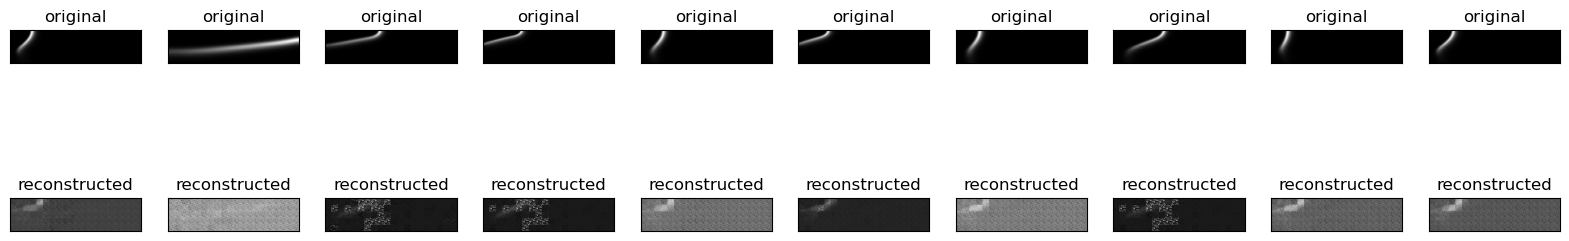

In [115]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test_data[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [89]:
# def decoder(input_decoder):
#     model = tf.keras.Sequential([
#                 tf.keras.Input(shape=input_decoder),
                
#                 # Fully NN 9x9x64
#                 tf.keras.layers.Dense(units = 1*4*64, name='dense_1'),
#                 tf.keras.layers.Reshape(target_shape = (1,4,64), name='reshape_1'),
                
#                 # Conv layer 
#                 tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=5, 
#                                                 padding='same', name='conv_tr_1'),
#                 tf.keras.layers.BatchNormalization(name='bn_1'),
#                 tf.keras.layers.LeakyReLU(name='lrelu_1'),
                
#                 # Conv layer  
#                 tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=5,
#                                                 padding='same', name='conv_tr_2'),
#                 tf.keras.layers.BatchNormalization(name='bn_2'),
#                 tf.keras.layers.LeakyReLU(name='lrelu_2'),
                
#                 # Conv layer 
#                 tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=3, 
#                                                 padding='same', name='conv_tr_3'),
#                 tf.keras.layers.BatchNormalization(name='bn_3'),
#                 tf.keras.layers.acitivation.sigmoid(),
                
#                 # # Conv layer 
#                 # tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), 
#                 #                                 padding='same', name='conv_tr_4'),
#                 # tf.keras.layers.BatchNormalization(name='bn_4'),
#                 # tf.keras.layers.LeakyReLU(name='lrelu_4') ,         
                
#                 # # Conv layer 
#                 # tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(2, 2), 
#                 #                                 padding='same', name='conv_tr_5'),
#                 # tf.keras.layers.BatchNormalization(name='bn_5'),
#                 # tf.keras.layers.LeakyReLU(name='lrelu_5'),           
                               
            
#     ], name='Decoder')

#     return model

# dec = decoder(input_decoder)

# dec.summary()


AttributeError: module 'keras.api._v2.keras.layers' has no attribute 'Sigmoid'

In [60]:
# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

# def ae_loss(y_true, y_pred):
#     loss = tf.keras.losses.mean_squared_error(y_true,y_pred)
#     return loss

In [61]:
# # @tf.function
# # def train_step(images):

# #     with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
# #         latent = enc(images, training=True)
# #         generated_images = dec(latent, training=True)
# #         loss = ae_loss(images, generated_images)
        
# #     gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
# #     gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
# #     optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
# #     optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
# #     return loss

# def cae(dataset, epochs):
#   latent = enc(dataset)
#   pre_images = dec(latent)
  
#   for epoch in range(epochs):
#     start = time.time()
#     for image_batch in dataset:
#       train_step(image_batch)
 
#     print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


# train(train_data, epochs = 50)

ValueError: in user code:

    File "C:\Users\zzhuqshun\AppData\Local\Temp\ipykernel_16592\16548166.py", line 6, in train_step  *
        latent = enc(images, training=True)
    File "c:\Users\zzhuqshun\.conda\envs\AppliedDL2023\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\zzhuqshun\.conda\envs\AppliedDL2023\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "Encoder" is incompatible with the layer: expected shape=(None, 75, 300, 1), found shape=(75, 300, 1)
